## Set working directory

In [ ]:
import os
os.chdir('/local/home/mhoerold/entrack')

## Imports

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import nibabel as nib
import copy

from src.baum_vagan.vagan.model_wrapper import VAGanWrapper
from src.baum_vagan.utils import ncc
from src.data.streaming.vagan_streaming import MRIImagePair, AgeFixedDeltaStream
from src.baum_vagan.utils import map_image_to_intensity_range
from src.data.streaming.mri_streaming import MRISingleStream
%matplotlib inline

## Load model for evaluation

In [ ]:
smt_label = "20180823-185855"
smallest_age_gap = 1
config_path = os.path.join("data", smt_label, "config.yaml")
model_dir = os.path.join("data", smt_label, "logdir")
with open(config_path, 'r') as f:
    model_config = yaml.load(f)
wrapper = VAGanWrapper(**model_config)
wrapper.vagan.load_weights(model_dir)
vagan = wrapper.vagan

In [ ]:
## Some streamers
train_stream = lambda bs: wrapper.data.trainAD.next_batch(bs)[0]
validation_stream = lambda bs: wrapper.data.validationAD.next_batch(bs)[0]
test_stream = lambda bs: wrapper.data.testAD.next_batch(bs)[0]

n_train_samples = wrapper.data.n_train_samples
n_val_samples = wrapper.data.n_val_samples
n_test_samples = wrapper.data.n_test_samples

# Input wrapper
input_wrapper = wrapper.config.input_wrapper
gt_channel = 2

In [ ]:
train_val_pairs = wrapper.data.train_pairs + wrapper.data.val_pairs
train_patient_ids = set()
for pair in train_val_pairs:
    patient_id = wrapper.data.get_patient_id(pair.fid1)
    train_patient_ids.add(patient_id)
    
single_config = copy.deepcopy(wrapper.data.config)
single_config["use_diagnoses"] = ['healthy', 'health_ad']
single_stream = MRISingleStream(single_config)

all_patient_ids = set()
for fid in single_stream.all_file_ids:
    all_patient_ids.add(single_stream.get_patient_id(fid))
    
hc_test_fids = set()
ad_test_fids = set()
for fid in single_stream.all_file_ids:
    pid = single_stream.get_patient_id(fid)
    if pid not in train_patient_ids:
        diag = single_stream.get_diagnose(fid)
        if diag == "healthy":
            hc_test_fids.add(fid)
        elif diag == "health_ad":
            ad_test_fids.add(fid)
            
hc_test_fids = list(hc_test_fids)
ad_test_fids = list(ad_test_fids)

In [ ]:
def extract_x_t0_x_t1_delta_x_t0(batch):
    x_t0 = batch[:, :, :, 0:1]
    delta_x_t0 = batch[:, :, :, 2:3]
    x_t1 = x_t0 + delta_x_t0
    return x_t0, x_t1, delta_x_t0

## Compute scores (e.g. NCC)

In [ ]:
streamers = [
    {
        "streamer": test_stream,
        "name": "test",
        "n_samples": n_test_samples
    },
    {
        "streamer": validation_stream,
        "name": "validation",
        "n_samples": n_val_samples
    },
]

for s in streamers:
    stream = s["streamer"]
    name = s["name"]
    n_samples = s ["n_samples"]
    print("Evaluating {}".format(name))
    scores = []
    for _ in range(n_samples):
        inp = stream(1)
        diff_map = vagan.predict_mask(inp)
        # wrapped = input_wrapper(inp)
        gt = inp[:, :, :, gt_channel:gt_channel + 1]
        sc = ncc(diff_map, gt)
        scores.append(sc)
        
    print("NCC: mean {}, std {}, median {}"
          .format(np.mean(scores), np.std(scores), np.median(scores)))

## Analyze slices of generated difference map

In [ ]:
def difference_map_comparison(diff_map_1, diff_map_2):
    nrows = 1
    ncols = 3
    
    plt.figure(figsize=(20, 10))
    # Difference
    plt.subplot(nrows, ncols, 1)
    im = diff_map_2 - diff_map_1
    plt.imshow(im, cmap='bwr')
    plt.title("map2 - map1")
    plt.axis('off')
    
    # Absolute difference
    plt.subplot(nrows, ncols, 2)
    im = np.abs(diff_map_1 - diff_map_2)
    plt.imshow(im, cmap='gray')
    plt.title("Absolute difference")
    plt.axis('off')
    
    # Element-wise product
    plt.subplot(nrows, ncols, 3)
    im = diff_map_1 * diff_map_2
    plt.imshow(im, cmap='bwr', vmin=-1, vmax=1)
    ncc_sc = round(ncc(diff_map_1, diff_map_2)[0], 4)
    plt.title("Element-wise product, ncc={}".format(str(ncc_sc)))
    plt.axis('off')
    
def plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, im_pair):
    x_t1_gen = x_t0 + delta_gen
    
    t0 = round(im_pair.age1, 2)
    t1 = round(im_pair.age2, 2)
    
    x_t0 = np.squeeze(x_t0)
    x_t1 = np.squeeze(x_t1)
    delta_x_t0 = np.squeeze(delta_x_t0)
    delta_gen = np.squeeze(delta_gen)
    x_t1_gen = np.squeeze(x_t1_gen)
    
    figsize = (20, 20)
    fs = 20
    fig = plt.figure(figsize=figsize, edgecolor='black', linewidth=0.1)
    plt.subplots_adjust(hspace=0.2, bottom=0.1)
    
    ax1 = fig.add_subplot(231)
    ax1.set_title("x_t0 {}, delta = {}".format(str(t0), im_pair.approx_delta), size=fs)
    ax1.imshow(x_t0, cmap='gray')
    
    ax2 = fig.add_subplot(232)
    ax2.set_title("delta_x_t0", size=fs)
    ax2.imshow(delta_x_t0, cmap='bwr', vmin=-2, vmax=2)
    
    ax3 = fig.add_subplot(233)
    ax3.set_title("x_t1 {}".format(str(t1)), size=fs)
    ax3.imshow(x_t1, cmap='gray')
    
    ax4 = fig.add_subplot(235)
    ax4.set_title("generated delta_x_t0", size=fs)
    ax4.imshow(delta_gen, cmap='bwr', vmin=-2, vmax=2)
    
    ax5 = fig.add_subplot(236)
    ax5.set_title("generated x_t1", size=fs)
    ax5.imshow(x_t1_gen, cmap='gray')
    
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.axis('off')
        
    fig.tight_layout()
    
    difference_map_comparison(delta_gen, delta_x_t0)
    
n_samples = 20
pairs = wrapper.data.test_pairs
np.random.seed(11)
np.random.shuffle(pairs)
for im_pair in pairs[:n_samples]:
    inp = np.array([im_pair.load()])
    x_t0, x_t1, delta_x_t0 = extract_x_t0_x_t1_delta_x_t0(inp)
    delta_gen = vagan.predict_mask(inp)
    x_t1_gen = x_t0 + delta_gen
    
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, im_pair)

## Iterative predictions

In [ ]:
deltas = list(range(2, 11))
tol = 0.2
config = copy.deepcopy(wrapper.data.config)
delta_to_streamer = {}
for delta in deltas:
    config["delta_min"] = delta - tol
    config["delta_max"] = delta + tol
    config["normalize_images"] = False
    config["silent"] = True
    try:
        streamer = AgeFixedDeltaStream(config)
        streamer.all_pairs = streamer.train_pairs + streamer.test_pairs + streamer.val_pairs
        # Only keep patients not used during model training
        keep_pairs = []
        for pair in streamer.all_pairs:
            pid = pair.streamer.get_patient_id(pair.fid1)
            if pid not in train_patient_ids:
                keep_pairs.append(pair)
                
        streamer.all_pairs = keep_pairs
        np.random.seed(11)
        np.random.shuffle(streamer.all_pairs)
        delta_to_streamer[delta] = streamer
    except:
        print("No streamer for delta = {}".format(delta))

In [42]:
def iterate_model(model, img, n_steps, only_negative=False):
    images = []
    masks = []
    # placeholder needs a second channel not used by generator
    delta_channel = img * 0 + 1.0
    img = np.concatenate((img, delta_channel, img), axis=-1)
    img = np.array([img])  # make a batch of size 1
    for _ in range(n_steps):
        M = model.predict_mask(img)
        if only_negative:
            M[M >= 0] = 0
        masks.append(np.squeeze(M))
        img += M
        img[:, :, :, 1] = delta_channel[:, :, 0]
        images.append(np.squeeze(img[:, :, :, 0]))
        # placeholder needs a second channel not used by generator
        # img = np.concatenate((img, img), axis=-1)
        
    return images, masks

In [ ]:
def plot_iterative_predictions(pair, delta, only_negative):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=pair.fid1,
        fid2=pair.fid2
    )
    t0 = round(wrapper.data.get_exact_age(pair.fid1), 2)
    tn = round(wrapper.data.get_exact_age(pair.fid2), 2)

    x_t0 = pair.load_image(pair.fid1)
    x_tn = pair.load_image(pair.fid2)
    age_gap = tn - t0
    n_steps = int(age_gap / smallest_age_gap)
    delta = n_steps
    images, masks = iterate_model(wrapper.vagan, x_t0, n_steps, only_negative)


    # plot predictions
    nrows = 2
    ncols = delta + 1
    fsize = 4
    plt.figure(figsize=(ncols * fsize, nrows * fsize))
    # plot images
    plt.subplot(nrows, ncols, 1)
    plt.imshow(np.squeeze(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    plt.axis('off')

    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i + 2)
        plt.imshow(np.squeeze(img), cmap='gray')
        plt.title('Generated x_t{}'.format(i + 1))
        plt.axis('off')

    # plot masks
    # concatenate differnce maps to plot with same scale
    plt.subplot(nrows, ncols, (ncols + 1, ncols + len(masks)))
    mask_slices = [m for m in masks]
    mask_slices_im = np.hstack(tuple(mask_slices))
    plt.imshow(mask_slices_im, cmap='bwr', vmin=-2, vmax=2)
    plt.title("Generated difference maps")
    plt.axis('off')
    """
    for i, mask in enumerate(masks):
        plt.subplot(nrows, ncols, ncols + 1 + i)
        plt.imshow(get_slice(mask), cmap='bwr')
        plt.title('Generated diff map at t{}'.format(i))
        plt.axis('off')
    """

    # plot gt
    plt.subplot(nrows, ncols, nrows * ncols)
    plt.imshow(np.squeeze(x_tn), cmap='gray')
    plt.title('x_t{}, age={}'.format(delta, str(tn)))
    plt.axis('off')
    
for delta in range(2, 6): 
    pairs = delta_to_streamer[delta].all_pairs[:5]
    plot_iterative_predictions(pairs[1], delta, only_negative=True)
    plot_iterative_predictions(pairs[0], delta, only_negative=True)

## Very far predictions

In [ ]:
def plot_far_prediction(pair, deltas=[10, 20, 30], only_negative=False):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=pair.fid1,
        fid2=pair.fid2
    )
    x_t0 = pair.load_image(pair.fid1)

    t0 = round(wrapper.data.get_exact_age(pair.fid1), 2)
    
    cur_inp = x_t0
    preds = []
    for i, delta in enumerate(deltas):
        steps = delta
        if i > 0:
            steps = deltas[i] - deltas[i - 1]
        steps = int(steps / smallest_age_gap)
        images, _ = iterate_model(wrapper.vagan, cur_inp, steps, only_negative)
        cur_inp = images[len(images) - 1][:, :]
        cur_inp = np.reshape(cur_inp, tuple(list(cur_inp.shape) + [1]))
        preds.append(np.copy(cur_inp))
    
    def get_slice(img):
        return np.squeeze(img)
    
    diff_maps = []
    diff_maps.append(get_slice(preds[0] - x_t0))
    for i in range(1, len(deltas)):
        diff_map = get_slice(preds[i] - preds[i - 1])
        diff_maps.append(diff_map)
    
    ncols = len(deltas) + 1
    nrows = 2
    fsize = 4
    plt.figure(figsize=(ncols * fsize, nrows * fsize))
    #plt.figure(figsize=(20, 20))
    plt.subplot(2, len(deltas) + 1, 1)
    plt.imshow(get_slice(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    plt.axis('off')
    
    for i, delta in enumerate(deltas):
        plt.subplot(2, len(deltas) + 1, i + 2)
        plt.imshow(get_slice(preds[i]), cmap='gray')
        plt.title("x_t{}".format(delta))
        plt.axis('off')
        
    # plot diff map
    plt.subplot(2, len(deltas) + 1, (1 + len(deltas) + 2, 1 + 2 * len(deltas) + 1))
    plt.imshow(np.hstack(tuple(diff_maps)), cmap='bwr', vmin=-2, vmax=2)
    plt.axis('off')

In [ ]:
pairs = delta_to_streamer[2].all_pairs[:10]
for i in range(7, 10):
    plot_far_prediction(pairs[i], deltas=[10, 20, 30], only_negative=True)

In [ ]:
pairs = delta_to_streamer[2].all_pairs[:10]
for i in range(7, 10):
    plot_far_prediction(pairs[i], deltas=[3, 6, 9])

## Smoothing GT difference maps

In [ ]:
def percentile_smooth(im, percentile=50):
    cp = np.copy(im)
    t = np.percentile(np.abs(cp), percentile)
    mask = np.abs(cp) < t
    cp[mask] = 0
    return cp
    
def hard_threshold(im, thresh=.8):
    cp = np.copy(im)
    mask = np.abs(cp) < thresh
    cp[mask] = 0
    return cp
    
pairs = wrapper.data.test_pairs
np.random.shuffle(pairs)
for im_pair in pairs[:n_samples]:
    im = im_pair.load()
    diff_map = im[:, :, :, 1]
    x_0 = im[:, :, :, 0]
    x_1 = x_0 + diff_map
    
    t0 = round(wrapper.data.get_exact_age(im_pair.fid1), 2)
    t1 = round(wrapper.data.get_exact_age(im_pair.fid2), 2)
    
    def get_slice(img):
        img = np.squeeze(img)
        return img[35, :, :]
    
    plt.figure(figsize=(20, 20))
    
    plt.subplot(2, 3, 1)
    plt.imshow(get_slice(x_0), cmap='gray')
    plt.title("x_0 {}".format(str(t0)))
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(get_slice(x_1), cmap='gray')
    plt.title("x_1 {}".format(str(t1)))
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(get_slice(x_0), cmap='gray')
    plt.imshow(get_slice(diff_map), cmap='bwr', alpha=0.7, vmin=-2, vmax=2)
    plt.title("x_0 and diff map")
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(get_slice(diff_map), cmap='bwr', vmin=-2, vmax=2)
    plt.title("Ground-truth")
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(get_slice(percentile_smooth(diff_map, 95)), cmap='bwr', vmin=-2, vmax=2)
    plt.title("95 percentile threshold")
    plt.axis('off')
               
    plt.subplot(2, 3, 6)
    plt.imshow(get_slice(hard_threshold(diff_map, .3)), cmap='bwr', vmin=-2, vmax=2)
    plt.title("0.3 threshold")
    plt.axis('off')
    

## Difference map intensity analysis

In [ ]:
from bisect import bisect_right
def intensity_score(diff_map):
    return np.mean(np.abs(diff_map))

def per_step_analysis(fids, max_steps):
    max_steps = 5
    diff_intensities = [[] for i in range(max_steps)]
    for fid in fids:
        some_pair = wrapper.data.train_pairs[0]
        x_t0 = some_pair.load_image(fid)

        images, masks = iterate_model(wrapper.vagan, x_t0, max_steps)
        for i in range(max_steps):
            sc = intensity_score(masks[i])
            diff_intensities[i].append(sc)

    values = np.array(diff_intensities)
    mean = np.mean(values, axis=1)
    plt.figure()
    plt.xlabel("i-th iteration")
    plt.ylabel("mean difference intensity")
    plt.plot(mean)
    
def per_age_analysis(fids, ages=[50, 60, 70, 80, 90, 100]):
    n_intervals = len(ages) - 1
    diff_intensities = [[] for i in range(n_intervals)]
    for fid in fids:
        some_pair = wrapper.data.train_pairs[0]
        x_t0 = some_pair.load_image(fid)
        t0 = single_stream.get_exact_age(fid)
        
        images, masks = iterate_model(wrapper.vagan, x_t0, 1)
        sc = intensity_score(masks[0])
        interval_id = bisect_right(ages, t0) - 1
        diff_intensities[interval_id].append(sc)
    
    # remove empty lists
    keep = []
    x = []
    means = []
    for i, intens in enumerate(diff_intensities):
        if len(intens) > 0:
            keep.append(intens)
            means.append(np.mean(intens))
            x.append(ages[i])
    
    plt.figure()
    plt.xlabel("t0 age")
    plt.ylabel("mean difference intensity")
    plt.plot(x, means)

In [ ]:
per_step_analysis(hc_test_fids, 5)

In [ ]:
per_age_analysis(hc_test_fids)

## Compare Real vs Fake time series

In [35]:
len(hc_test_fids)

2780

In [36]:
len(ad_test_fids)

4475

In [37]:
def get_gt_time_series(file_ids, target_delta=1):
    patient_groups = single_stream.make_patient_groups(file_ids)
    patient_to_series = {}

    for g in patient_groups:
        fids = g.file_ids
        
        pid = single_stream.get_patient_id(fids[0])
        patient_to_series[pid] = []
        
        diagnoses = set([])
        for fid in g.file_ids:
            diag = single_stream.get_diagnose(fid)
            diagnoses.add(diag)
        # multiple diagnoses
        if len(diagnoses) > 1:
            continue

        # Determine which images can be used
        # Sort by ascending age
        age_ascending = sorted(
            g.file_ids,
            key=lambda x: single_stream.get_exact_age(x)
        )

        # Filter out same age images
        n = len(age_ascending)

        to_remove = []
        for i in range(1, n):
            prev_age = single_stream.get_exact_age(age_ascending[i - 1])
            cur_age = single_stream.get_exact_age(age_ascending[i])
            if prev_age == cur_age:
                to_remove.append(i)
        to_remove.reverse()
        for i in to_remove:
            del age_ascending[i]
            
        n = len(age_ascending)
        for i in range(n):
            i_fid = age_ascending[i]
            age_i = single_stream.get_exact_age(i_fid)
            series = [i_fid]
            last_age = age_i
            for j in range(i + 1, n):
                j_fid = age_ascending[j]
                age_j = single_stream.get_exact_age(j_fid)
                delta = age_j - last_age
                if target_delta - 0.2 <= delta <= target_delta + 0.2:
                    series.append(j_fid)
                    last_age = age_j
                    
            if len(series) > 1:
                patient_to_series[pid].append(series)
                
    return patient_to_series

In [40]:
patient_to_series = get_gt_time_series(hc_test_fids)
chosen = []
for pid, series in patient_to_series.items():
    # sort series by length
    ss = sorted(series, key=lambda x: -len(x))
    if len(ss) < 1:
        continue
    p = ", ".join(str(single_stream.get_exact_age(fid)) for fid in ss[0])
    r = ", ".join(str(single_stream.get_image_label(fid)) for fid in ss[0])
    print("{}: {}".format(pid, p))
    print(r)
    chosen.append(ss[0])

027_S_0120: 72.1479, 73.1753, 74.2055, 75.2027, 76.1945, 77.1534, 78.2685, 79.2055, 80.3288, 81.2466
10934, 40994, 93249, 137014, 166618, 216139, 291187, 361390, 419898, 477249
116_S_1249: 70.9014, 71.8986, 72.8959, 73.8959, 74.9671, 75.9288, 76.9425
38467, 90054, 135219, 165819, 222009, 286071, 360823
128_S_0230: 80.0877, 81.126, 82.1616
11806, 46544, 100582
033_S_0920: 80.1123, 81.1836, 82.1534, 83.1945, 84.1726
25012, 80844, 119458, 157857, 196520
018_S_0425: 85.8658, 87.0219, 88.0
13980, 57055, 108830
126_S_0605: 75.6712, 76.6822, 77.7151, 78.6767, 79.7123, 80.7288, 81.7096, 82.7068
17204, 57472, 111746, 146765, 181022, 244002, 313123, 381108
003_S_4288: 72.5397, 73.5753
262283, 378914
021_S_0159: 77.9699, 79.063, 80.0658, 81.0959, 82.0959, 83.1973, 84.0685, 85.0521, 86.0877, 87.0685
10590, 42623, 95362, 139122, 167930, 229066, 287919, 361608, 417135, 476647
22: 81.0, 82.0
A136617, A162208
362: 63.0, 64.0
A169753, A190720
006_S_0681: 77.0932, 78.2247, 79.2247
23677, 78213, 121917
0

In [150]:
def plot_series_gt_vs_predicted(file_ids, horizontal=True):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=file_ids[0],
        fid2=file_ids[-1]
    )
    t0 = round(wrapper.data.get_exact_age(pair.fid1), 2)
    tn = round(wrapper.data.get_exact_age(pair.fid2), 2)

    x_t0 = pair.load_image(pair.fid1)
    x_tn = pair.load_image(pair.fid2)
    age_gap = tn - t0
    n_steps = len(file_ids) - 1
    delta = n_steps
    images, masks = iterate_model(wrapper.vagan, x_t0, n_steps)

    gt_images = [pair.load_image(fid) for fid in file_ids]
    gt_diffs = []
    for i in range(1, len(gt_images)):
        gt_diffs.append(gt_images[i] - gt_images[i - 1])

    def plot_diff_maps(masks, n_series, series_len):
        # plot masks
        # concatenate differnce maps to plot with same scale
        fsize = 4
        if horizontal:
            plt.figure(figsize=(series_len * fsize, 1 * fsize))
        else:
            plt.figure(figsize=(1 * 8, series_len * 8))
            
        ncols = series_len
        plt.subplot(1, ncols, (1, series_len))
        mask_slices = [np.squeeze(m) for m in masks]
        if horizontal:
            if n_series == 1:
                mask_slices_im = np.hstack(tuple(mask_slices))
            #print(mask_slices_im.shape)
            elif n_series == 2:
                im1 = np.hstack(tuple(mask_slices[:series_len]))
                im2 = np.hstack(tuple(mask_slices[series_len:]))
                mask_slices_im = np.vstack((im1, im2))
        else:
            if n_series == 1:
                mask_slices_im = np.vstack(tuple(mask_slices))
            elif n_series == 2:
                im1 = np.vstack(tuple(mask_slices[:series_len]))
                im2 = np.vstack(tuple(mask_slices[series_len:]))
                mask_slices_im = np.vstack((im1, im2))
            
        plt.imshow(mask_slices_im, cmap='bwr', vmin=-1, vmax=1)
        plt.title("Difference maps")
        plt.axis('off')
        # plot predictions
        
    def plot_brain_series(images, nrows, ncols, title):
        fsize = 4
        plt.figure(figsize=(ncols * fsize, nrows * fsize))
        plt.title(title)

        for i, img in enumerate(images):
            plt.subplot(nrows, ncols, i + 1)
            plt.imshow(np.squeeze(img), cmap='gray')
            plt.title('{} x_t{}'.format(title, i))
            plt.axis('off')
    
    k = len(gt_images)
    title = "GT Image"
    if horizontal:
        plot_brain_series(gt_images, 1, k, title)
    else:
        plot_brain_series(gt_images, k, 1, title)

    k = len(images) + 1
    title = "Generated Image"
    if horizontal:
        plot_brain_series([x_t0] + images, 1, k, title)
    else:
        plot_brain_series([x_t0] + images, k, 1, title)
        
    plot_diff_maps(gt_diffs + masks, 2, len(masks))
    """
    # plot images
    plt.subplot(nrows, ncols, 1)
    plt.imshow(np.squeeze(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    plt.axis('off')


    # plot gt
    plt.subplot(nrows, ncols, nrows * ncols)
    plt.imshow(np.squeeze(x_tn), cmap='gray')
    plt.title('x_t{}, age={}'.format(delta, str(tn)))
    plt.axis('off')
    """
    
    # Plot series side by side
    L = len(file_ids)
    

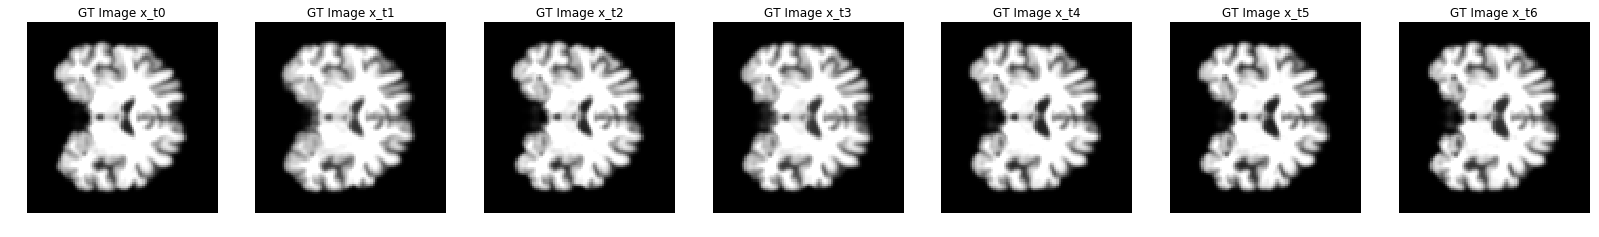

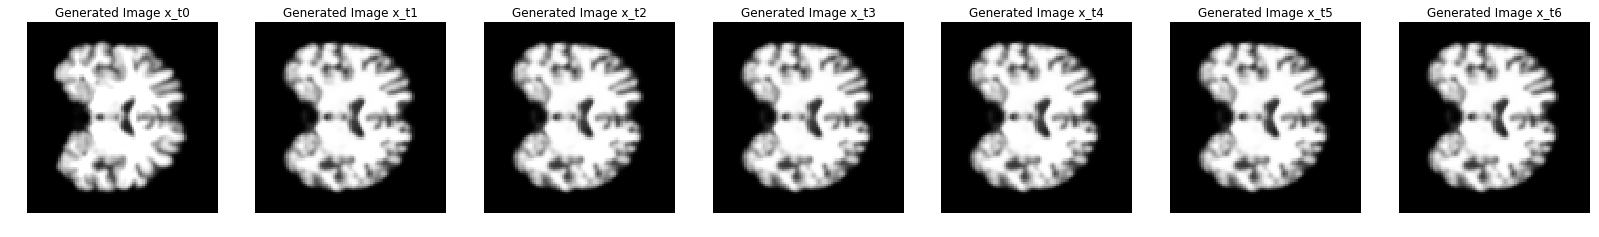

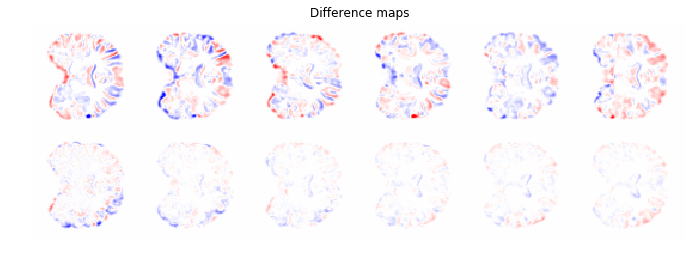

In [151]:
plot_series_gt_vs_predicted(chosen[1], True)